# Performances


## Counting triangles

In [1]:
import networkx as nx
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
from path import Path
PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
os.chdir (PROJ_DIR)


In [3]:
import scripts.src.CountingTriangles as ct
from scripts.src.ClosenessCentrality import *

In [4]:
def generateGraph(start=100, stop=500, step=100, density=0.70):
    listOfNetworks=[]
    for numberOfNodes in range(start, stop, step):
        numberOfEdges=int((density/2)*numberOfNodes*(numberOfNodes-1))
        graph= nx.gnm_random_graph(numberOfNodes, numberOfEdges, seed=42)
        listOfNetworks.append(graph)
    return listOfNetworks

def execution_time(listOfNetworks, counter, repeat=5):
    times={}
    for graph in listOfNetworks:
        time=[]
        for i in range(repeat):
            starttime = timeit.default_timer()
            counter.run(graph)
            #time in second
            time.append(timeit.default_timer() - starttime)
        times[(type(counter).__name__,len(graph.nodes._nodes))]=time
    return times

def create_dataset_times(listOfNetworks):
    listOfClasses=[ct.ObviousAlgorithm(),ct.EnumeratingNeighborPairs(), ct.DelegatingLowDegreeVertices()]
    times={}
    for myClass in listOfClasses:
        current_times=execution_time(listOfNetworks, myClass, repeat=10)
        times.update(current_times)
    times_dataframe= pd.DataFrame.from_dict(times)
    times_dataframe = times_dataframe.unstack().reset_index().drop("level_2", axis=1)
    times_dataframe=times_dataframe.rename(columns={"level_0": "class", "level_1":"numberOfNodes",0:"time"})
    return times_dataframe

def barplot(dataframe, density):
    plt.title("Execution Times for graph with density {}".format(density))
    barplot=sns.barplot(x="class", y="time", hue="numberOfNodes", data=dataframe)
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

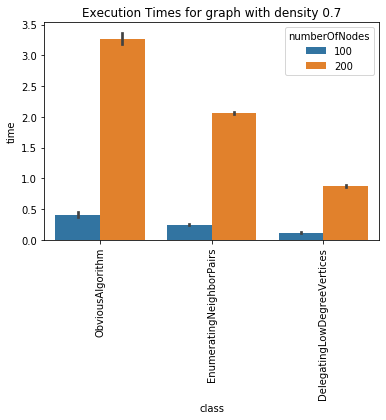

In [5]:
listOfNetworks=generateGraph(stop=300)
times_dataset=create_dataset_times(listOfNetworks)
barplot(times_dataset, 0.70)
plt.show()

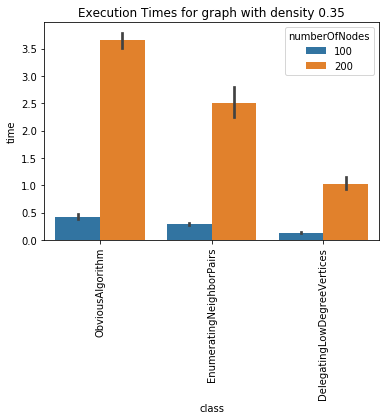

In [6]:
listOfNetworks2=generateGraph(stop=300, density=0.35)
times_dataset=create_dataset_times(listOfNetworks)
barplot(times_dataset, 0.35)
plt.show()


## Closeness Centrality

In [7]:
def compute_error(expected, actual):
    result=[]
    for key in actual.keys():
        c_hat=1/actual[key]
        c=1/expected[key]
        abs_error = abs(c_hat - c)
        result.append(abs_error)
    return np.array(result)

In [8]:
R=nx.read_adjlist(DATA_DIR/"R.adjlist", delimiter=",")
largest_cc = max(nx.connected_components(R), key=len)
R=R.subgraph(largest_cc)
len(R)

2000

In [9]:
if not os.path.exists(DATA_DIR/"ErrorEW.csv"):
    expected = nx.closeness_centrality(R, wf_improved=False)
    df_performance = pd.DataFrame(columns=['epsilon', 'mean_error', 'std_error'])
    #epsilon_list = [0.2, 0.1, 0.07, 0.06, 0.05] #time of execution: 2 hours
    epsilon_list = [0.2]
    for e in epsilon_list:
        print(e)
        EW = EWAlgorithm(R, e)
        actual = EW.run()
        error =compute_error(expected, actual)
        mean_error=np.mean(error)
        std_error=np.std(error)
        df_performance=df_performance.append({'epsilon':e,'mean_error':mean_error, 'std_error':std_error}, ignore_index=True)
    df_performance.to_csv(DATA_DIR/"ErrorEW.csv")
else:
    df_performance=pd.read_csv(DATA_DIR/"ErrorEW.csv")
    

0.2
0.1


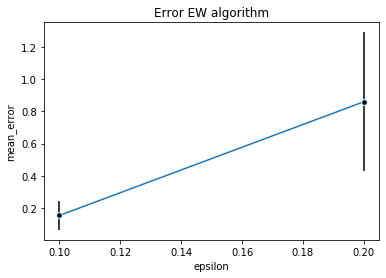

In [11]:
plt.title("Error EW algorithm")
plot=sns.lineplot(x="epsilon", y="mean_error", marker="o", data=df_performance)
plt.errorbar(df_performance["epsilon"], df_performance["mean_error"], yerr=df_performance["std_error"], fmt='.k')
plt.show()


